In [26]:
import pandas as pd
import numpy as np
from fsds.ingestion import fetch_housing_data, load_housing_data
from fsds.train import train_and_save_model, prepare_data, create_pipeline
from sklearn.ensemble import RandomForestRegressor

In [2]:
housing = load_housing_data()
# train_set, _ = prepare_data(housing)

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## EDA 

## Checking the distribution of each features and target variable

<Axes: xlabel='median_house_value', ylabel='Count'>

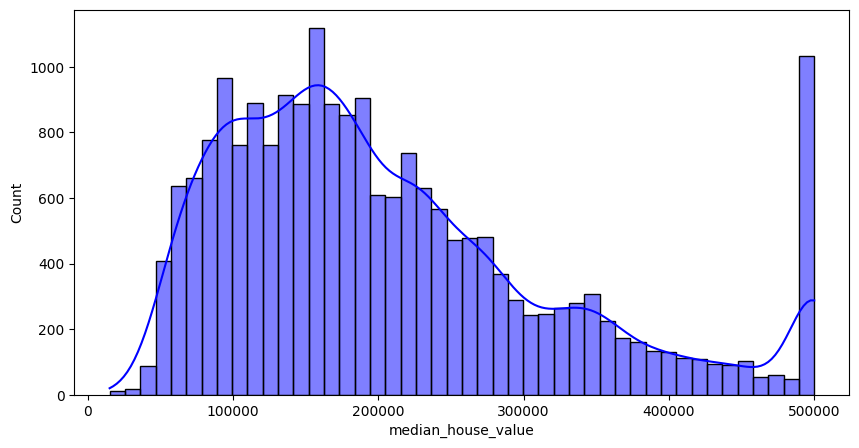

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# 1. Visualize Distribution
plt.figure(figsize=(10, 5))
sns.histplot(housing['median_house_value'], kde=True, color='blue')

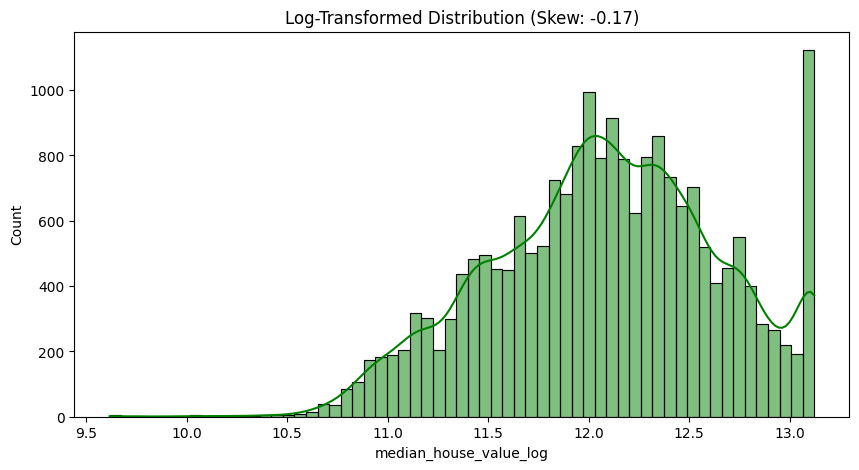

In [34]:
if abs(housing['median_house_value'].skew()) > 0.75:
    # np.log1p handles log(0) by adding 1 to the value
    housing['median_house_value_log'] = np.log1p(housing['median_house_value'])
    
    # Visualize Transformed Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(housing['median_house_value_log'], kde=True, color='green')
    plt.title(f"Log-Transformed Distribution (Skew: {housing['median_house_value_log'].skew():.2f})")
    plt.show()

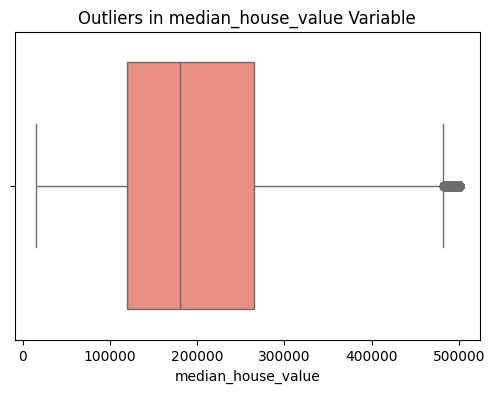

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


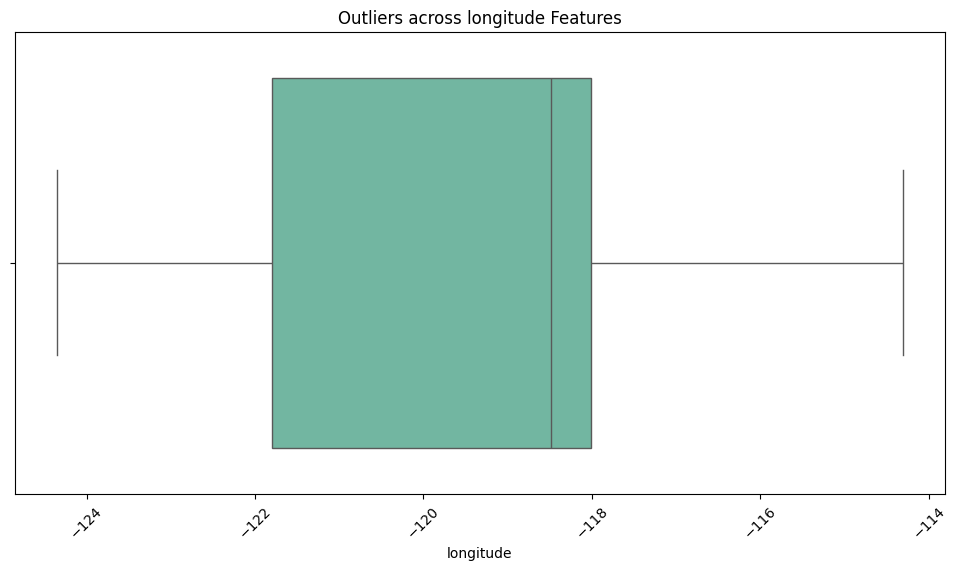

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


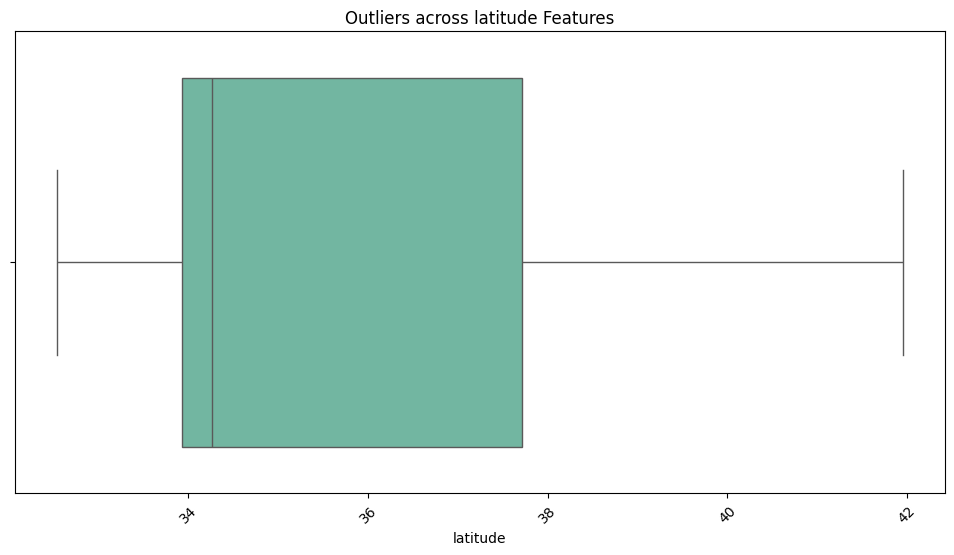

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


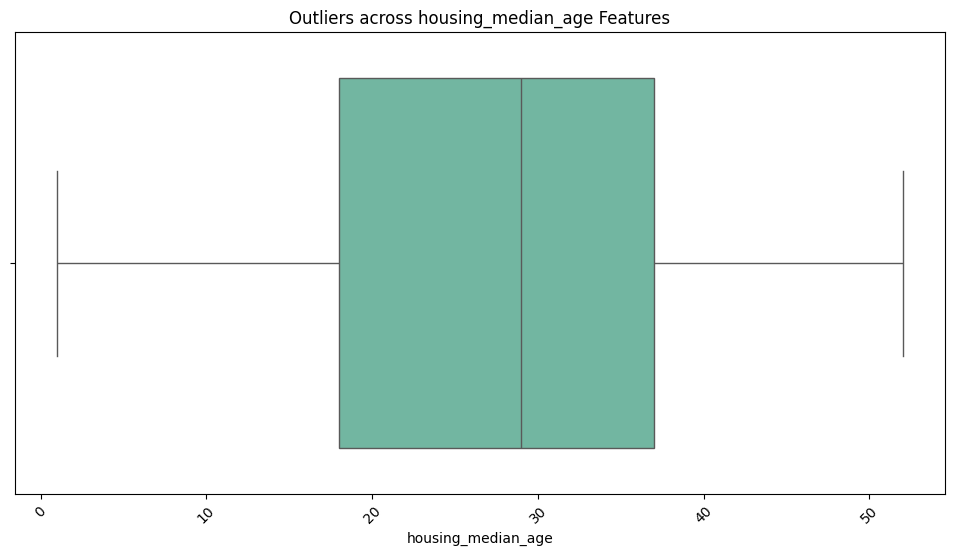

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


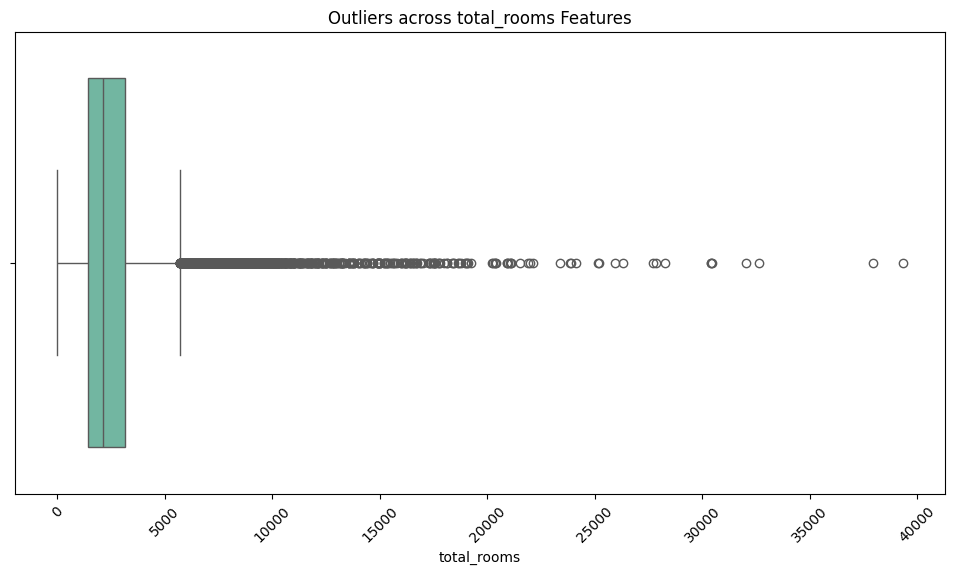

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


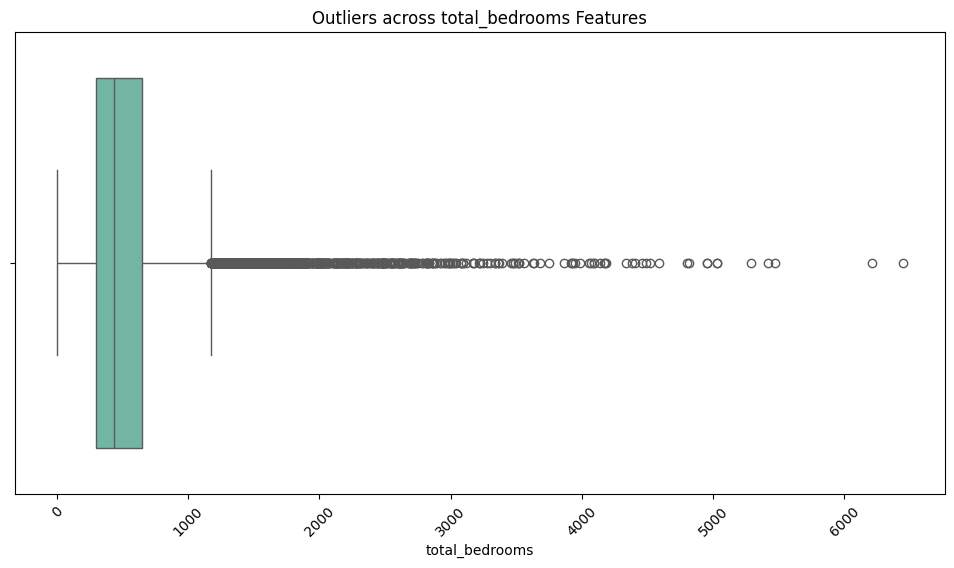

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


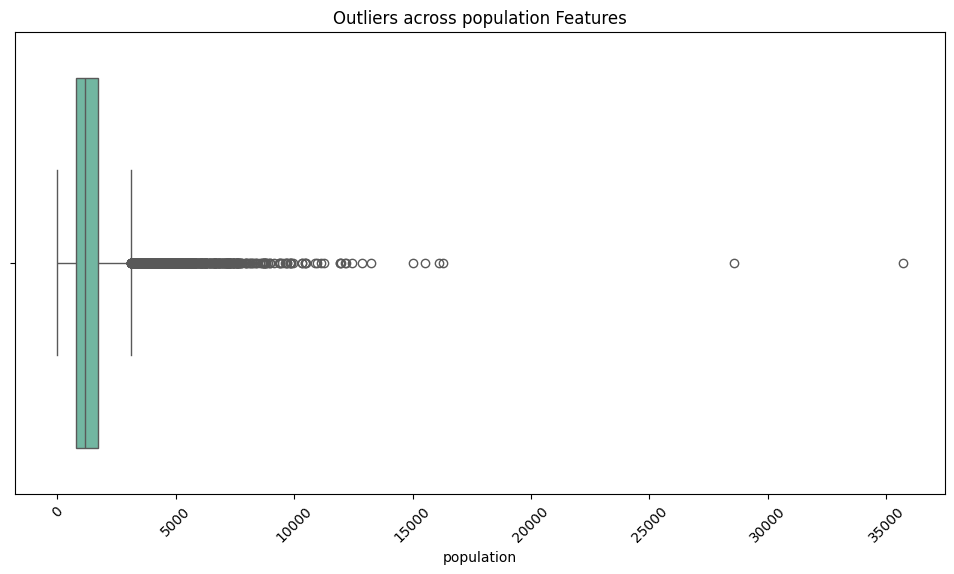

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


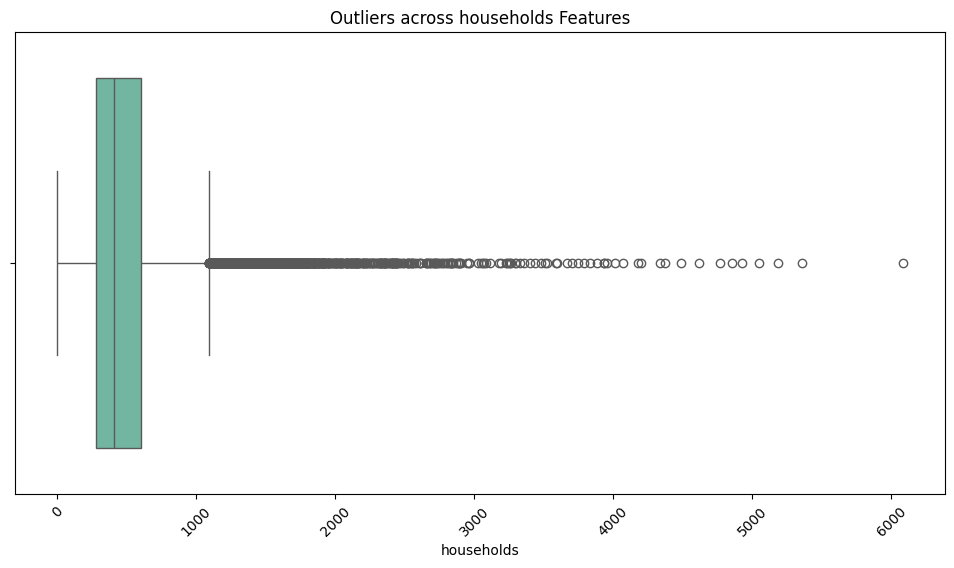

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


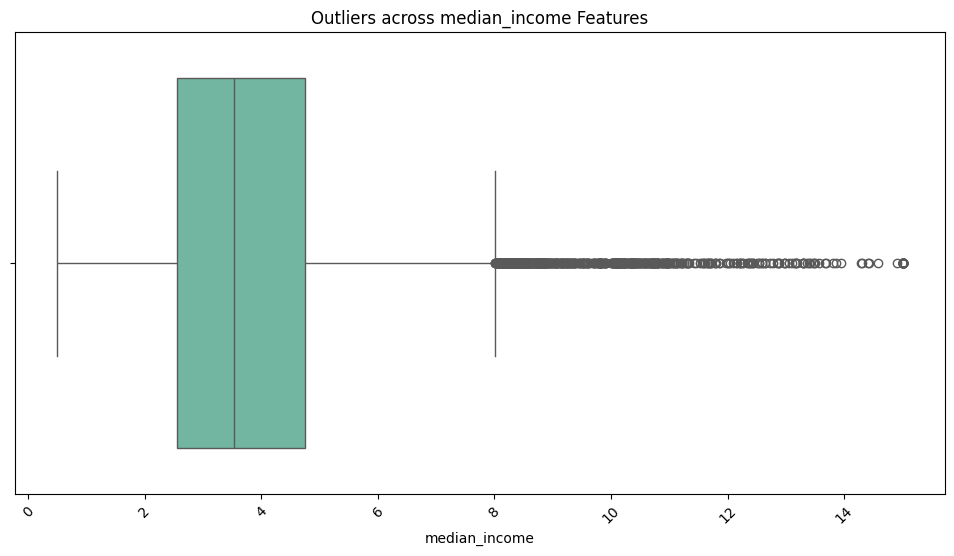

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


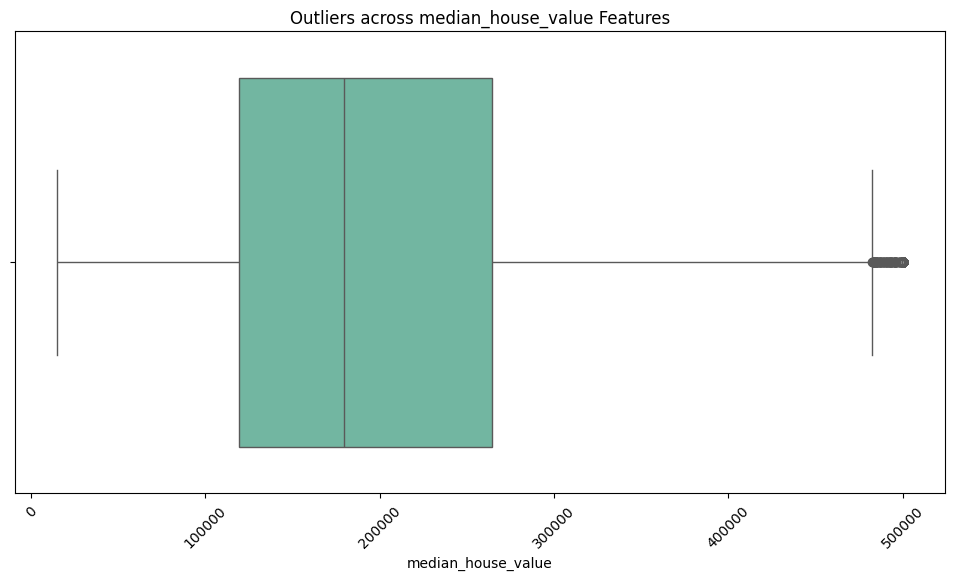

/tmp/ipykernel_78742/1817500935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing[feature], orient="h", palette="Set2")


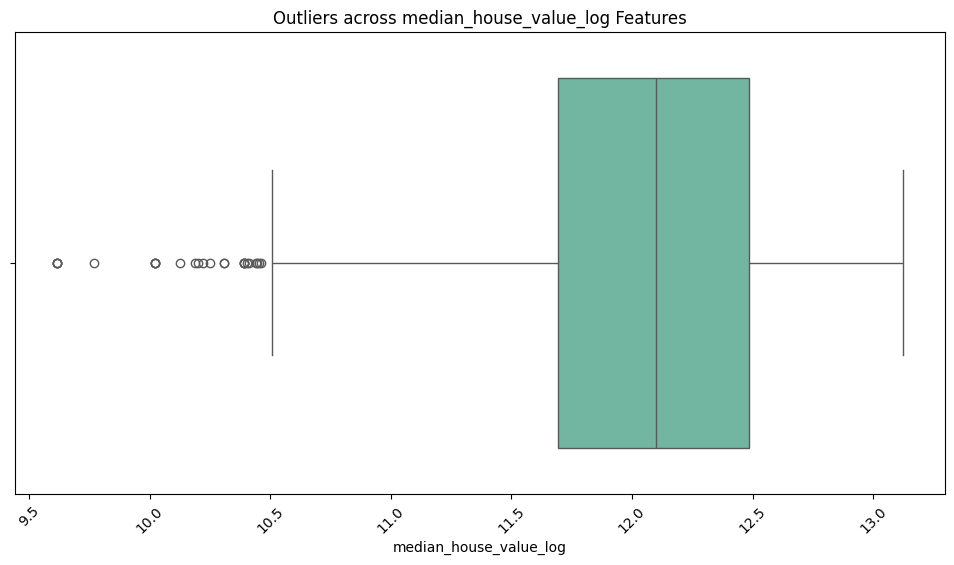

In [37]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=housing['median_house_value'], color='salmon')
plt.title('Outliers in median_house_value Variable')
plt.show()

# 2. Check Numerical Features for Outliers
# We'll filter for just numerical columns
num_features = housing.select_dtypes(include=['number']).columns
for feature in num_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=housing[feature], orient="h", palette="Set2")
    plt.title(f'Outliers across {feature} Features')
    plt.xticks(rotation=45)
    plt.show()

In [38]:
housing.count()

longitude                 20640
latitude                  20640
housing_median_age        20640
total_rooms               20640
total_bedrooms            20433
population                20640
households                20640
median_income             20640
median_house_value        20640
ocean_proximity           20640
income_cat                20640
median_house_value_log    20640
dtype: int64

## Tukeys IQR Method

In [51]:
from collections import Counter
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

In [50]:
len(multiple_outliers)

817

In [53]:
multiple_outliers= IQR_method(housing,2, num_features)
df_out = housing.drop(multiple_outliers, axis = 0).reset_index(drop=True)

Total number of outliers is: 26


In [54]:
df_out.count()

longitude                 19823
latitude                  19823
housing_median_age        19823
total_rooms               19823
total_bedrooms            19625
population                19823
households                19823
median_income             19823
median_house_value        19823
ocean_proximity           19823
income_cat                19823
median_house_value_log    19823
dtype: int64

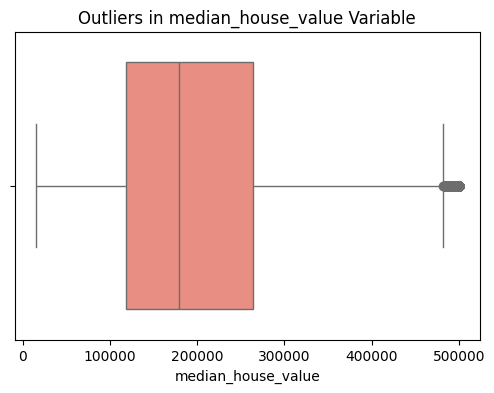

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


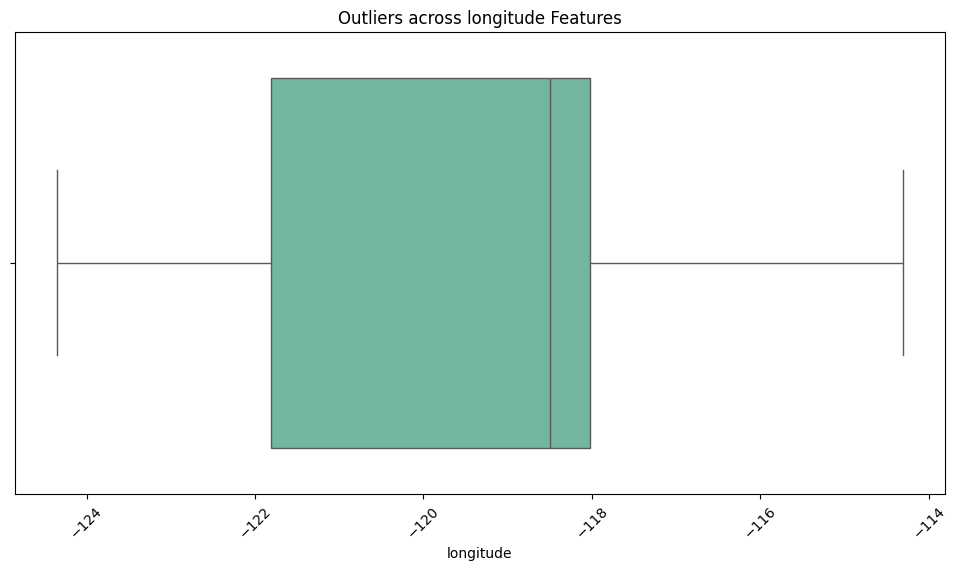

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


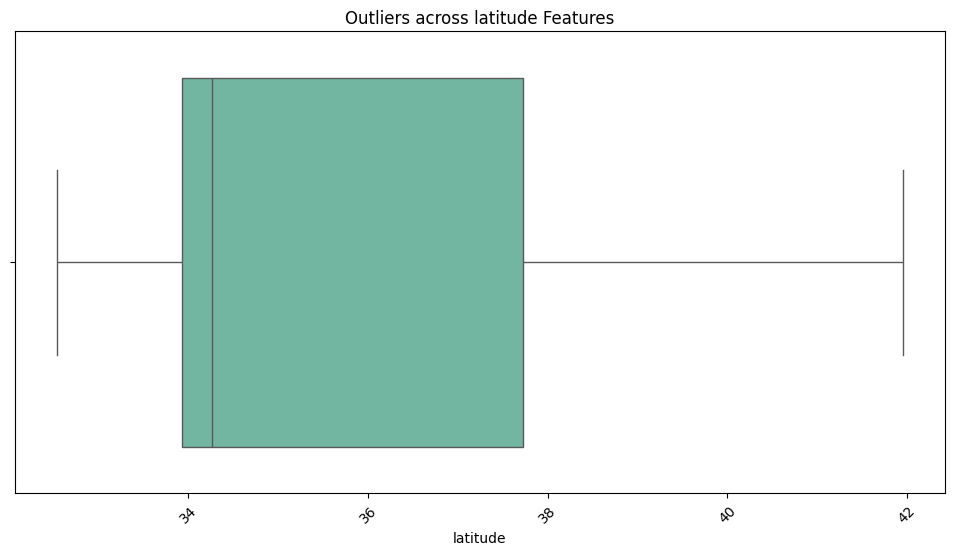

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


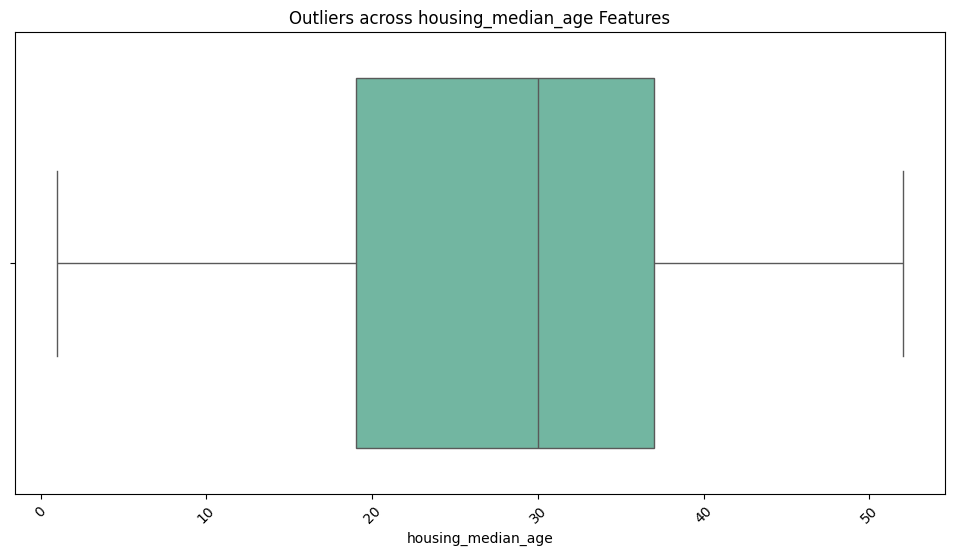

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


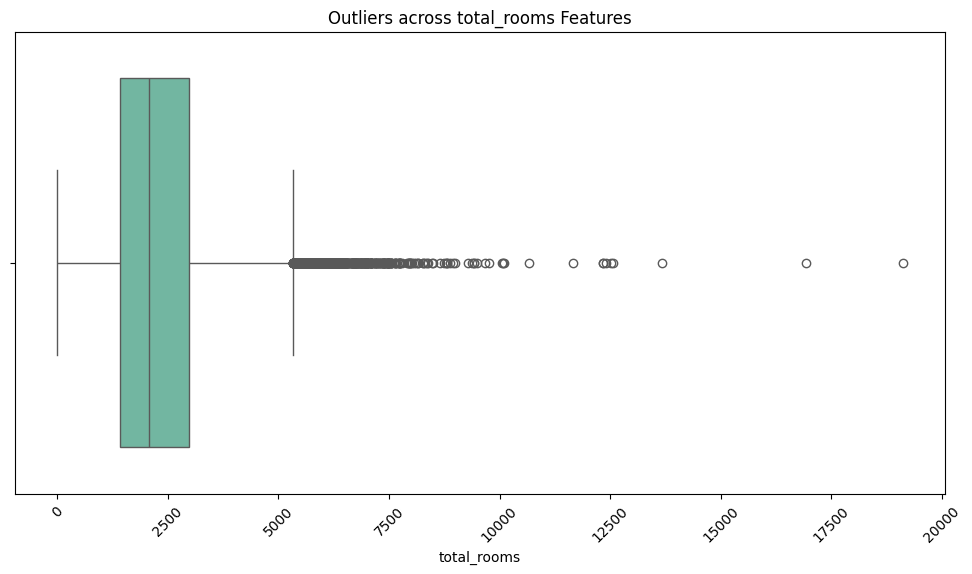

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


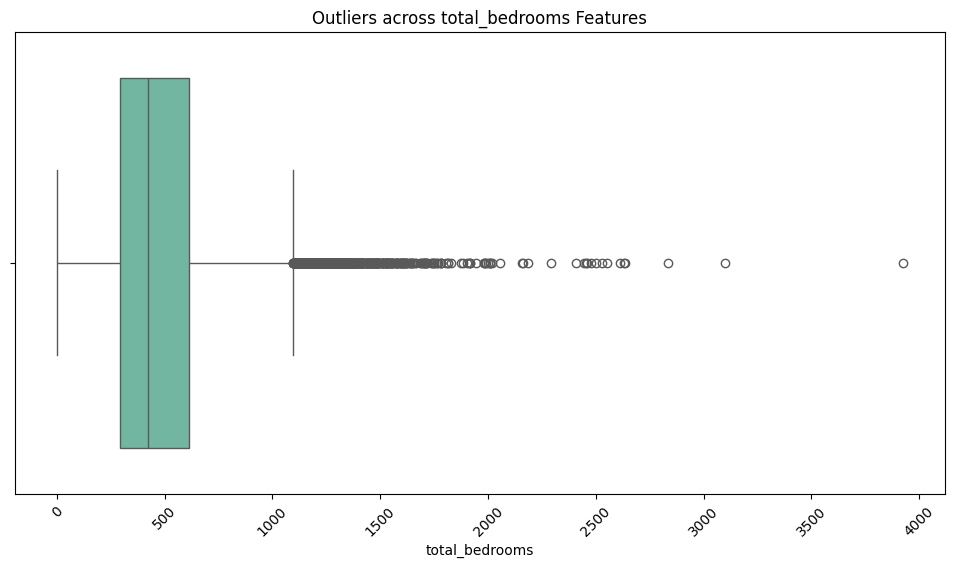

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


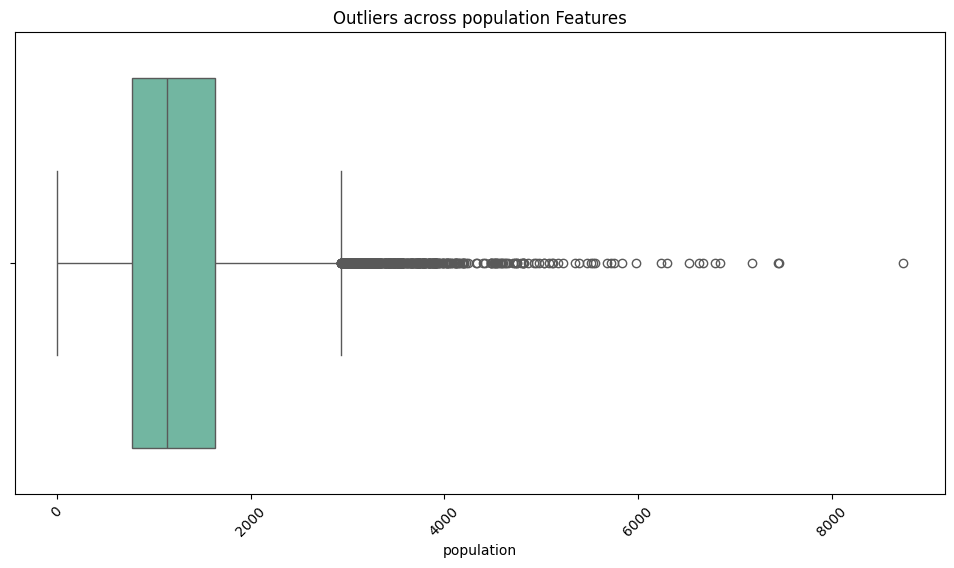

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


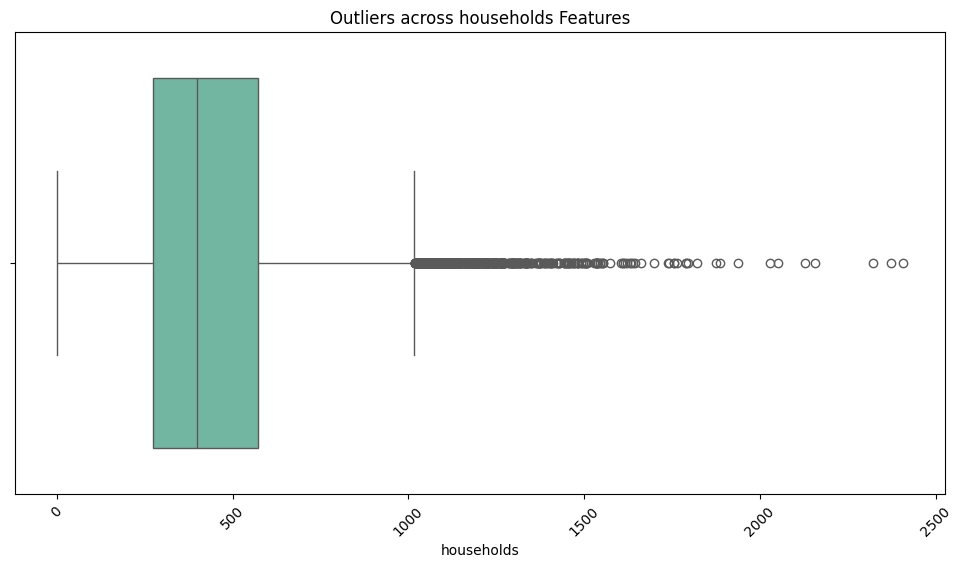

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


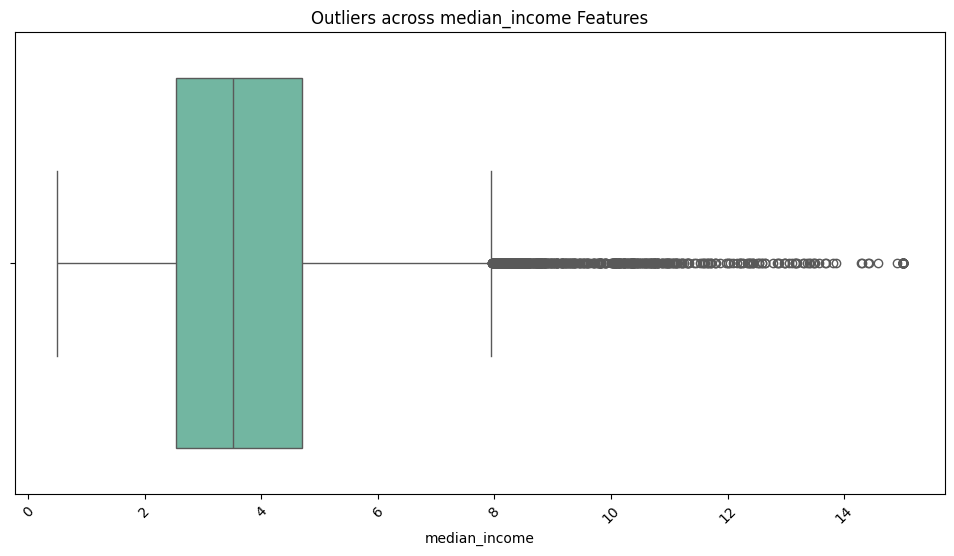

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


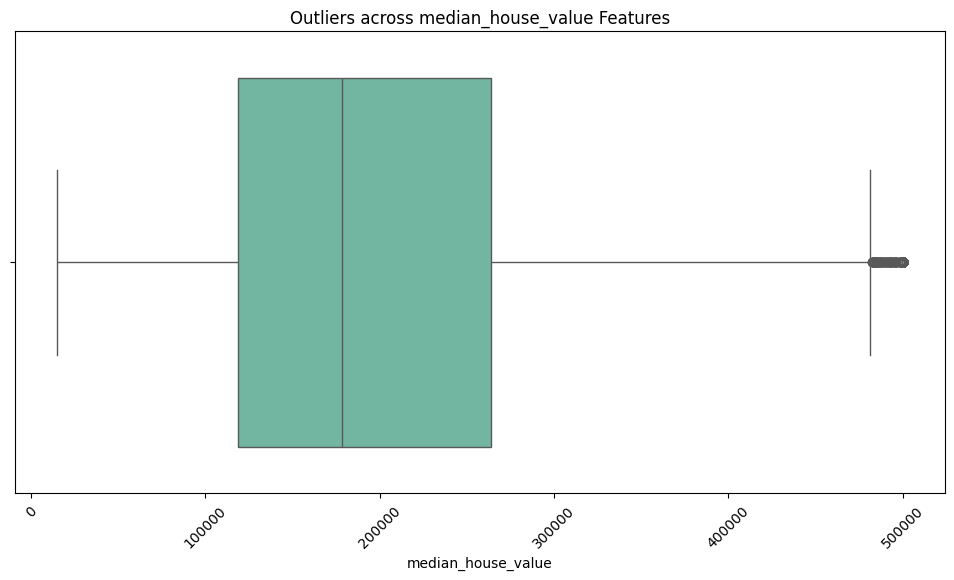

/tmp/ipykernel_78742/2584421471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out[feature], orient="h", palette="Set2")


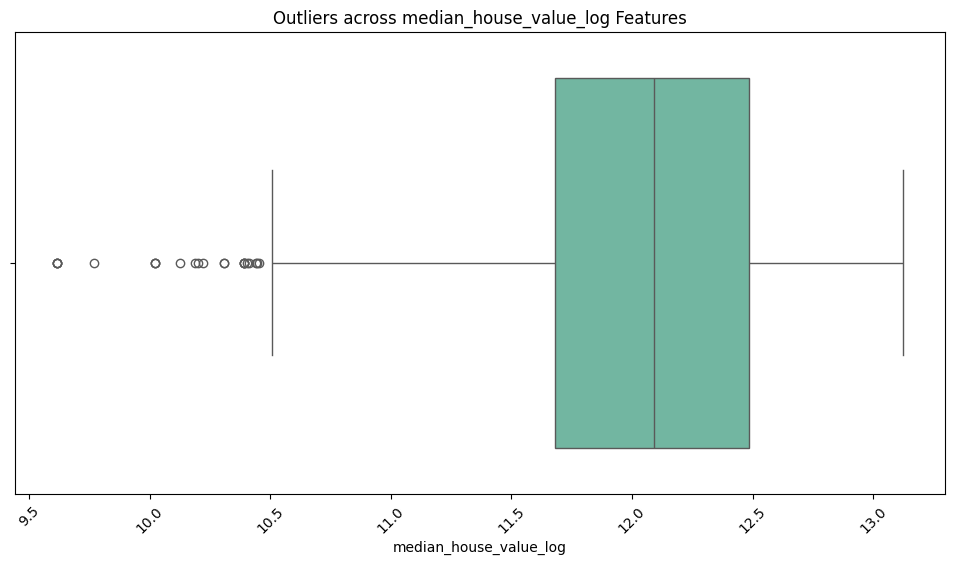

In [55]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_out['median_house_value'], color='salmon')
plt.title('Outliers in median_house_value Variable')
plt.show()

# 2. Check Numerical Features for Outliers
# We'll filter for just numerical columns
num_features = df_out.select_dtypes(include=['number']).columns
for feature in num_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_out[feature], orient="h", palette="Set2")
    plt.title(f'Outliers across {feature} Features')
    plt.xticks(rotation=45)
    plt.show()

In [22]:
train_set, _ = prepare_data(housing)

In [27]:
housing_labels = train_set["median_house_value"].copy()
housing_features = train_set.drop("median_house_value", axis=1)

housing_features["rooms_per_household"] = (
    housing_features["total_rooms"] / housing_features["households"]
)
housing_features["bedrooms_per_room"] = (
    housing_features["total_bedrooms"] / housing_features["total_rooms"]
)
housing_features["population_per_household"] = (
    housing_features["population"] / housing_features["households"]
)

num_attribs = housing_features.drop("ocean_proximity", axis=1).columns\
    .tolist()
cat_attribs = ["ocean_proximity"]

pipeline = create_pipeline(num_attribs, cat_attribs)
housing_prepared = pipeline.fit_transform(housing_features)

param_grid = {
    "n_estimators": [30, 50],
    "max_features": [6, 8],
}

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
grid_search.fit(housing_prepared, housing_labels)
print(grid_search.best_estimator_, grid_search.best_params_)
#  os.makedirs(os.path.dirname(model_path), exist_ok=True)
# joblib.dump((grid_search.best_estimator_, pipeline), model_path)
# print(f"Model saved to {model_path}")
# return grid_search.best_params_, grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=50, random_state=42) {'max_features': 6, 'n_estimators': 50}


In [30]:
grid_search.score

<bound method BaseSearchCV.score of GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_features': [6, 8], 'n_estimators': [30, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')>

In [ ]:
params, model = train_and_save_model()